In [1]:
import os
data_dir = './datasets/jena_climate/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

In [2]:
f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(f"header: \n{header}\n")
print(f"line length: {len(lines)}")

header: 
['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']

line length: 420451


In [3]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

In [4]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [5]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [6]:
import numpy as np
from tensorflow import keras

In [7]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [8]:
for samples, targets in train_dataset:
    print("sample shape:", samples.shape)
    print("target shape:", targets.shape)
    break

sample shape: (256, 120, 14)
target shape: (256,)


In [9]:
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

- 순환 드롭아웃(recurrent dropout)

In [10]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/20
819/819 [==============================] - 72s 87ms/step - loss: 27.6632 - mae: 3.8793 - val_loss: 9.7002 - val_mae: 2.4353
Epoch 2/20
819/819 [==============================] - 72s 88ms/step - loss: 14.6271 - mae: 2.9690 - val_loss: 9.8447 - val_mae: 2.4404
Epoch 3/20
819/819 [==============================] - 70s 86ms/step - loss: 13.6661 - mae: 2.8691 - val_loss: 9.4917 - val_mae: 2.3998
Epoch 4/20
819/819 [==============================] - 74s 90ms/step - loss: 13.1443 - mae: 2.8133 - val_loss: 9.2893 - val_mae: 2.3596
Epoch 5/20
819/819 [==============================] - 75s 91ms/step - loss: 12.6483 - mae: 2.7593 - val_loss: 9.2839 - val_mae: 2.3657
Epoch 6/20
819/819 [==============================] - 75s 92ms/step - loss: 12.3262 - mae: 2.7209 - val_loss: 9.7771 - val_mae: 2.4354
Epoch 7/20
819/819 [==============================] - 74s 91ms/step - loss: 11.9725 - mae: 2.6834 - val_loss: 9.3539 - val_mae: 2.3907
Epoch 8/20
819/819 [==============================] - 7

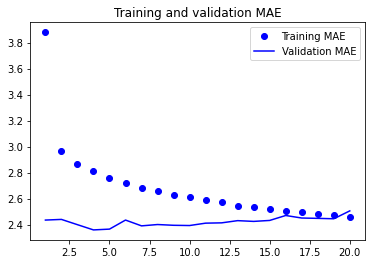

In [11]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

- Prediction

In [12]:
pred_train = model.predict(train_dataset)
pred_val = model.predict(val_dataset)
pred_test = model.predict(test_dataset)

print(f"train shape: {pred_train.shape}")
print(f"val shape: {pred_val.shape}")
print(f"test shape: {pred_test.shape}")

train shape: (209506, 1)
val shape: (104393, 1)
test shape: (103537, 1)


In [13]:
x_label = np.arange(pred_train.shape[0] + pred_val.shape[0] + pred_test.shape[0])
# x_label = x_label.reshape(len(x_label), 1)
print(f"x_label shape: {x_label.shape}")

x_label shape: (417436,)


In [14]:
train_start = 0
train_end = train_start + pred_train.shape[0]
x_train = x_label[train_start:train_end]
y_train = temperature[(delay + train_start):(delay + train_end)]

val_start = train_end
val_end = val_start + pred_val.shape[0]
x_val = x_label[val_start:val_end]
y_val = temperature[(delay + val_start):(delay + val_end)]

test_start = val_end
test_end = test_start + pred_test.shape[0]
x_test = x_label[test_start:test_end]
y_test = temperature[(delay + test_start):(delay + test_end)]

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")

print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (209506,)
y_train shape: (209506,)
x_val shape: (104393,)
y_val shape: (104393,)
x_test shape: (103537,)
y_test shape: (103537,)


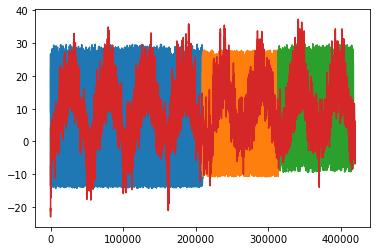

In [15]:
plt.figure()
plt.plot(x_train, pred_train)
plt.plot(x_val, pred_val)
plt.plot(x_test, pred_test)
plt.plot(temperature[delay:])
plt.show()